TRY THIS for autoencoder


scipy.stats.kstest

scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='approx')[source]
Perform the Kolmogorov-Smirnov test for goodness of fit.

This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.

In [1]:
#importing python libraries
import pandas as pd
import numpy as np
import math
from scipy.stats import normaltest

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from collections import Counter
warnings.filterwarnings('ignore')

#helps to visualize null values
import missingno as msno

#bokeh is used for tgraphs
from bokeh.core.properties import value
from bokeh.io import output_notebook
from bokeh.layouts import row, column, widgetbox, gridplot
from bokeh.models import ColumnDataSource, Legend, LabelSet
from bokeh.plotting import figure, show

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('train.csv')

In [3]:
#shape of the data
print('Shape of data: ', df.shape)

Shape of data:  (595212, 59)


In [4]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## Step 1: DataType Check

In [5]:
#49 columns have int type 
#and 10 have float type

#Checking what type of Data is present in df 
Counter(df.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [3]:
float_cols = df.select_dtypes(include=['float64']).columns.tolist()
#cat and bin column names
cat_col_names = [col for col in df.columns if '_cat' in col]
bin_col_names = [col for col in df.columns if '_bin' in col]

ord_col_names = []
for col in df.columns:
    if ('_cat' in col) or ('_bin' in col) or (col in ['id', 'target']) or (col in float_cols):
        a = 1
    else:
        ord_col_names.append(col)

In [7]:
print('Continuous variables: ', '\n',float_cols)

Continuous variables:  
 ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']


In [8]:
print('Categorical variables: ', '\n',cat_col_names)

Categorical variables:  
 ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


In [9]:
print('Binary variables: ', '\n',bin_col_names)

Binary variables:  
 ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


In [10]:
print('Ordinal variables: ', '\n',ord_col_names)

Ordinal variables:  
 ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']


## Useful Functions
These 3 functions are used later in the notebook.

In [4]:
'''
plot_cat_distri function returns a grid distribution plots for categorical type variables. x-axis displays 
categories and y-axis displays the percent of samples having those categories.
Parameters:
col_list: list of column names to be plotted
ncols: no of plots in a row
'''

output_notebook()
def plot_cat_distri(col_list, plot_height=150, plot_width=200, ncols=4):
    #list to collect plots
    plot_list = []

    for j in col_list:
        val_counts = df[j].value_counts().to_dict()

        names = []
        counts = []

        for i in val_counts:
            if type(i) is str:
                names.append(i)
                counts.append(val_counts[i])
            else:
                names.append(str(i))
                counts.append(val_counts[i])

        s_ = sum(counts)
        counts = [round(x/s_, 2) for x in counts]

        source = ColumnDataSource(data=dict(names=names, counts=counts))

        p = figure(x_range=names, plot_height=plot_height, plot_width=plot_width, title = j)

        p.vbar(x='names', top='counts', width=0.9, source=source)

        p.xgrid.grid_line_color = None
        p.xaxis.major_label_orientation = math.pi/2
        p.legend.orientation = "horizontal"
        p.legend.location = "top_right"
        
        #appending plots
        plot_list.append(p)
    
    #returning grid plot
    return gridplot(plot_list, ncols=ncols)

Loading BokehJS ...

In [5]:
'''
float_dist_plot returns a grid of histograms for continuous (float) columns. x-axis is the value ranges
and y-axis is the frequency
Parameters:
col_list: list of column names to be plotted
ncols: no of plots in a row
bins: no of bins for histogram
'''
def float_dist_plot(col_list, bins='auto',plot_height=150, plot_width=200, ncols=4):
    plot_list = []
    
    for j in col_list:
        #data for histogram, NaN are dropped
        d_ = df[j].dropna()
        hist, edges = np.histogram(d_, bins=bins)
        hist = hist/len(df[j])

        graph_title = " (μ={}, σ={})".format(round(d_.mean()),round(d_.std()))

        p = figure(title= graph_title,plot_height=plot_height, plot_width=plot_width)

        p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])

        p.xaxis.axis_label = j
        p.yaxis.axis_label = '% samples in bin'
        p.xaxis.major_label_orientation = math.pi/2

        plot_list.append(p)
    return gridplot(plot_list, ncols=ncols)

In [6]:
'''
removes the column from dataframe and its name from appropriate list
'''
def remove_col(col_name_list_):
    for col_name in col_name_list_:  
        df.drop([col_name],axis=1, inplace = True)
        if col_name in cat_col_names:
            cat_col_names.remove(col_name)
        elif col_name in float_cols:
            float_cols.remove(col_name)
        elif col_name in bin_col_names:
            bin_col_names.remove(col_name)
        elif col_name in ord_col_names:
            ord_col_names.remove(col_name)

## Step 2: Null Value Inspection

In [15]:
#Null or missing values check

'''How to find the null values sum per column is below'''
#df.isnull().sum()

'''It is given that: Values of -1 indicate that the feature was missing from the observation
so lets try to visualize the missing data'''

'It is given that: Values of -1 indicate that the feature was missing from the observation\nso lets try to visualize the missing data'

In [16]:
df_copy = df
#replacing -1 with Null values
df_copy = df_copy.replace(-1, np.NaN)

df_copy.isnull().sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        216
ps_ind_03              0
ps_ind_04_cat         83
ps_ind_05_cat       5809
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         107772
ps_car_01_cat        107
ps_car_02_cat          5
ps_car_03_cat     411231
ps_car_04_cat          0
ps_car_05_cat     266551
ps_car_06_cat          0
ps_car_07_cat      11489
ps_car_08_cat          0
ps_car_09_cat        569
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          42620
ps_car_15              0
ps_calc_01             0


In [ ]:
# Nullity or missing values by columns
msno.matrix(df=df_copy.iloc[:,2:20], figsize=(25, 14), color=(0.42, 0.1, 0.05))

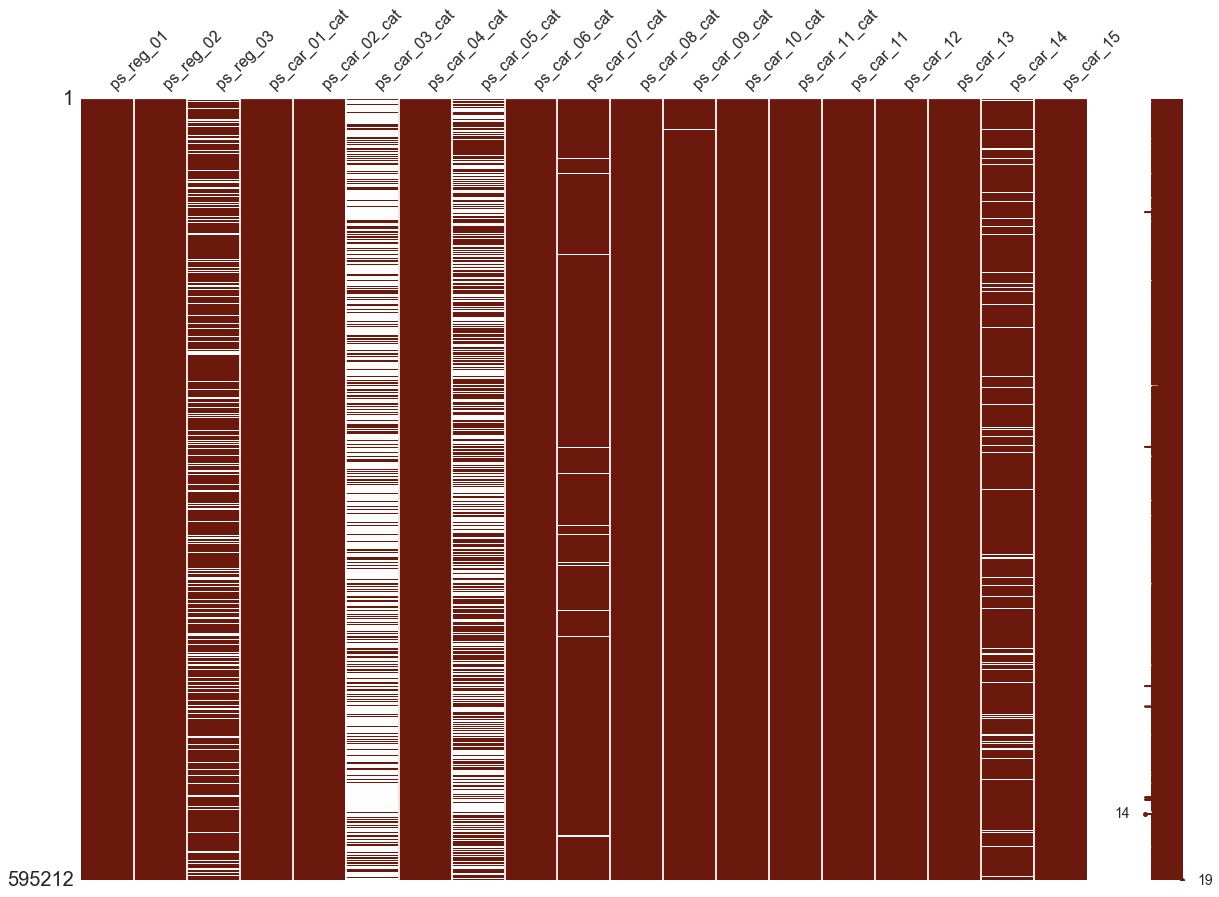

In [9]:
# Nullity or missing values by columns
msno.matrix(df=df_copy.iloc[:,20:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

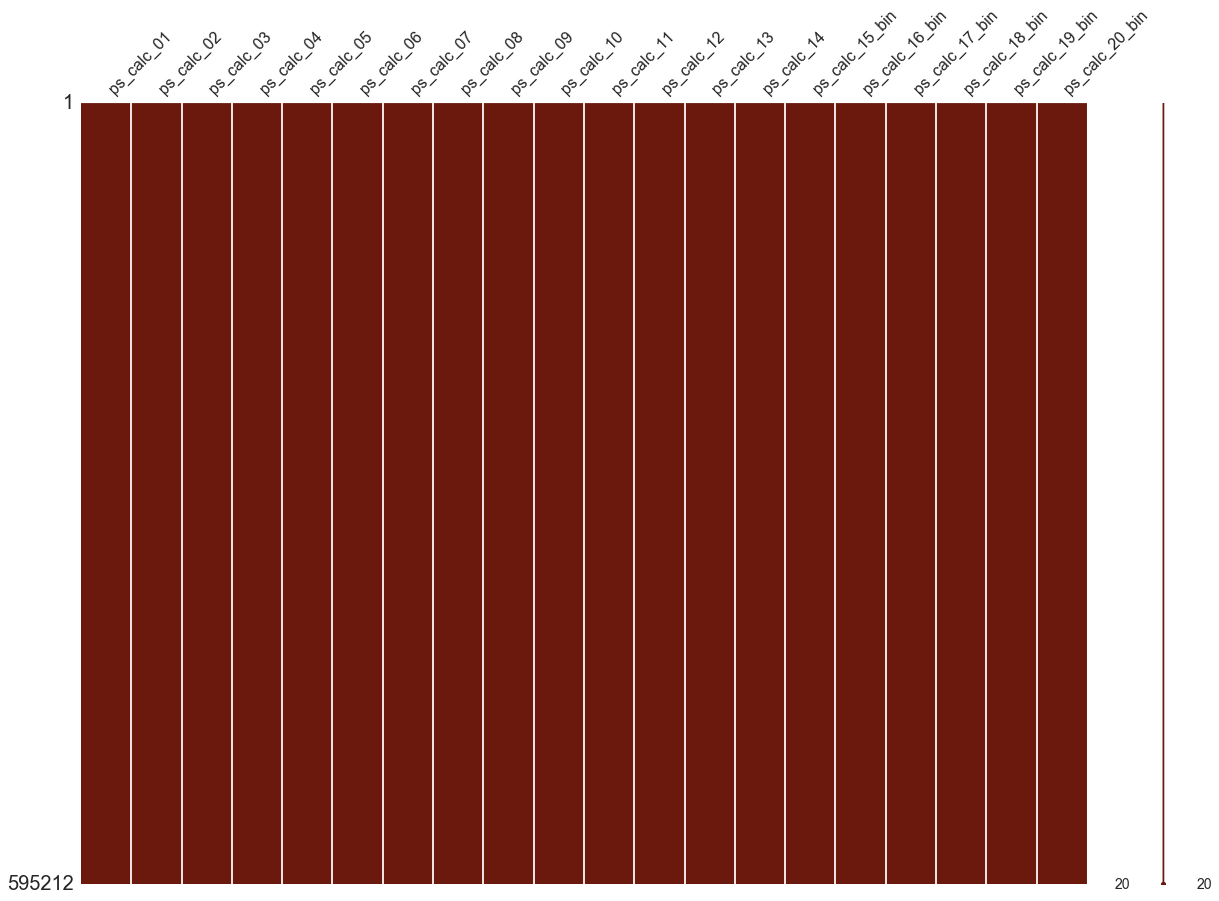

In [10]:
msno.matrix(df=df_copy.iloc[:,39:59], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [17]:
del(df_copy)

### Measures taken: Dropping Columns

ps_car_03_cat, ps_car_05_cat

Do it in corr step after checking for normality to replace null with mean or median
(Omitting ps_reg_03 as its showing a 0.73 correl with ps_reg_01 and contains a lot of null values.)

In [7]:
print(df.shape)
remove_col(['ps_car_03_cat','ps_car_05_cat'])
print(df.shape)

(595212, 59)
(595212, 57)


In [4]:
'''
#dropping all -1 values from the dataframe
df = df[~(df == -1).any(axis = 1)]
print(df.shape)
'''

(541860, 56)


## Step 3: Target Class Distribution Visual Inspection

In [8]:
show(plot_cat_distri(['target'], plot_height= 300, plot_width=400))

## Step 4: Binary Variables Distribution Inspection


In [9]:
show(plot_cat_distri(bin_col_names))

In [14]:
candidates_ = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin','ps_ind_13_bin']
a = len(df[df.target == 1])
for candi in candidates_:
    df_temp = df[['target', candi]]
    df_temp = df_temp[df_temp[candi] == 1]
    df_temp = df_temp[df_temp['target'] == 1]
    print(candi, len(df_temp),' percentage: ',len(df_temp)*100/a)

ps_ind_10_bin 12  percentage:  0.05531483359454227
ps_ind_11_bin 46  percentage:  0.21204019544574537
ps_ind_12_bin 289  percentage:  1.3321655757352264
ps_ind_13_bin 29  percentage:  0.13367751452014381


In [8]:
print(df.shape)
remove_col(['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin','ps_ind_13_bin'])
print(df.shape)

(595212, 57)
(595212, 53)


As we can see the minority level of each of the above column contains very few 1s in the target column, it is safe to omit them

Four binary variables here are dominated by a single class. So there is not point in including them. Omission should depend on the target value of minority class rows of above variable. 

## Step 5: Categorical features Distribution Inspection

In [1]:
show(plot_cat_distri(cat_col_names))

NameError: name 'show' is not defined

In [17]:
show(plot_cat_distri(['ps_car_11_cat'], plot_height= 300, plot_width=400))

In [18]:
candidates_ = ['ps_car_10_cat']
a = len(df[df.target == 1])
for candi in candidates_:
    df_temp = df[['target', candi]]
    if candi == 'ps_ind_05_cat' or candi == 'ps_car_04_cat':
        df_temp = df_temp[df_temp[candi] != 0]
    else:
        df_temp = df_temp[df_temp[candi] != 1]
    df_temp = df_temp[df_temp['target'] == 1]
    print(candi, len(df_temp),' percentage: ',len(df_temp)*100/a)

ps_car_10_cat 174  percentage:  0.8020650871208629


In [10]:
print(df.shape)
remove_col(['ps_car_10_cat'])
print(df.shape)

(595212, 53)
(595212, 52)


## Step 6: Ordinal Variable Distribution Inspection

In [10]:
show(plot_cat_distri(ord_col_names))

In [9]:
#dropping
remove_col(['ps_ind_14'])

In [22]:
from scipy.stats import shapiro

for col in ord_col_names:
    stat, pvalue = shapiro(df[col].dropna().tolist())
    print(col, 'pvalue: ',pvalue)

ps_ind_01 pvalue:  0.0
ps_ind_03 pvalue:  0.0
ps_ind_15 pvalue:  0.0
ps_car_11 pvalue:  0.0
ps_calc_04 pvalue:  0.0
ps_calc_05 pvalue:  0.0
ps_calc_06 pvalue:  0.0
ps_calc_07 pvalue:  0.0
ps_calc_08 pvalue:  0.0
ps_calc_09 pvalue:  0.0
ps_calc_10 pvalue:  0.0
ps_calc_11 pvalue:  0.0
ps_calc_12 pvalue:  0.0
ps_calc_13 pvalue:  0.0
ps_calc_14 pvalue:  0.0


## Step7: Continuous Variable Distribution Inspection
(Histogram plots) To check whether they are following a Normal Distribution

In [16]:
show(float_dist_plot(float_cols,plot_height=300, plot_width=300, ncols=3,bins=20))

#### Normality Test
It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

In [24]:
for col in float_cols:
    stat, pvalue = shapiro(df[col].dropna().tolist())
    print(col, 'pvalue: ',pvalue)

ps_reg_01 pvalue:  0.0
ps_reg_02 pvalue:  0.0
ps_reg_03 pvalue:  0.0
ps_car_12 pvalue:  0.0
ps_car_13 pvalue:  0.0
ps_car_14 pvalue:  0.0
ps_car_15 pvalue:  0.0
ps_calc_01 pvalue:  0.0
ps_calc_02 pvalue:  0.0
ps_calc_03 pvalue:  0.0


For normal test null hypothesis is that the values follow normal distribution. pvalue for that test is close to zero (considering alpha as 0.05). So, we reject the null hypothesis. Variables does not follow normal distribution. So we can't substitute mean in place of null values. Instead, we will use median.

### Substituting Median in place of Null values

In [16]:
for col in ord_col_names+float_cols:
    med = df[col].median()
    df[col].replace(-1, med, inplace=True)

## Step 8: Correlation Plots

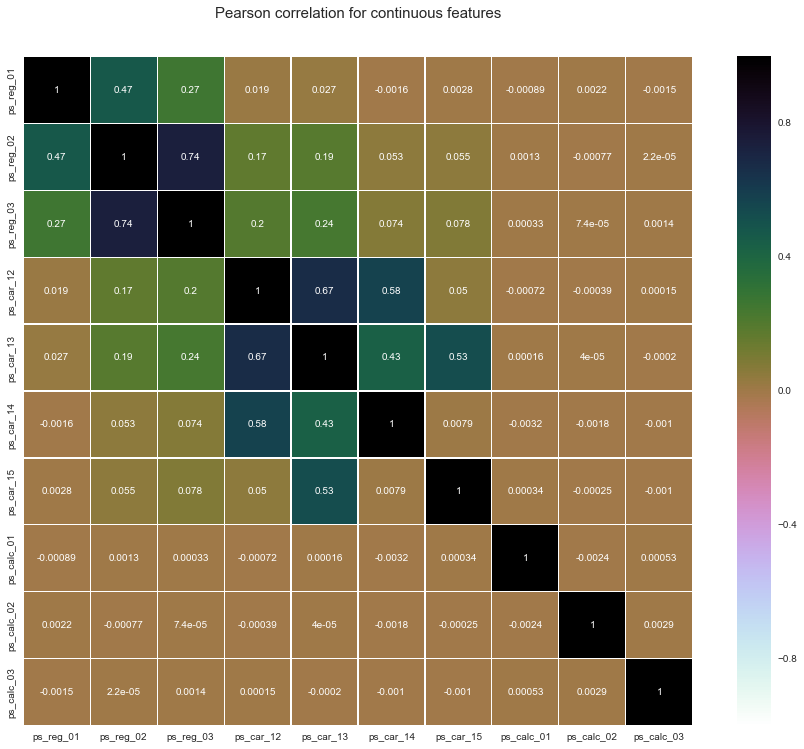

In [19]:
'''
Lets analyze the correlation between the float type variables/columns.
'''

df_float = df[float_cols]

colormap = plt.cm.cubehelix_r
plt.figure(figsize=(16,12))
plt.title('Pearson correlation for continuous features', y=1.05, size=15)
sns.heatmap(df_float.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Multicollinearity

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
x_m = df[float_cols].as_matrix()
print(np.shape(x_m))

(595212, 10)


In [23]:
#calculating VIF for float columns
for j in range(len(float_cols)):
    mc = [i for i in range(np.shape(x_m)[1])]
    mc.remove(j)
    y_ = x_m[:,j]
    x_ = x_m[:, mc]
    lr = LinearRegression()
    lr.fit(x_, y_)
    r2 = lr.score(x_, y_)
    print (float_cols[j], ' Variance Inflation Factor (VIF): ', 1/(1-r2))

ps_reg_01  Variance Inflation Factor (VIF):  1.31688765195
ps_reg_02  Variance Inflation Factor (VIF):  2.72593735254
ps_reg_03  Variance Inflation Factor (VIF):  2.3126852335
ps_car_12  Variance Inflation Factor (VIF):  2.72220718971
ps_car_13  Variance Inflation Factor (VIF):  3.42726219885
ps_car_14  Variance Inflation Factor (VIF):  1.52592572443
ps_car_15  Variance Inflation Factor (VIF):  1.84448590033
ps_calc_01  Variance Inflation Factor (VIF):  1.00002565707
ps_calc_02  Variance Inflation Factor (VIF):  1.0000305239
ps_calc_03  Variance Inflation Factor (VIF):  1.00001877067


As you can see VIF of all variables is less than 10 and near to one (if vif > 10 then there is multicollinearity). So, there is no multi collinearity between these float variables.

### Measures Taken
http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/

## Mutual Information

In [6]:
from sklearn.feature_selection import mutual_info_classif 

ImportError: cannot import name 'mutual_info_classif'

In [5]:
mf = sklearn.feature_selection.mutual_info_classif(df_float.values,df.target.values,n_neighbors=3, random_state=17)

AttributeError: module 'sklearn' has no attribute 'feature_selection'

## Feature importance via Random Forest
Let us now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking of the features after the model has finished training. This is a quick way of using an ensemble model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances.

In [8]:
#array of features of independent variables used
features = df.drop(['id', 'target'],axis=1).columns.values
features = features.tolist()
print(features)

['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


##### Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [9]:
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(df.drop(['id', 'target'],axis=1), df.target)

KeyboardInterrupt: 

In [19]:
#importance of features, all elements of below array sum to one.
a = rf.feature_importances_

##### Gradient Boosting Classifier
GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

In [20]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(df.drop(['id', 'target'],axis=1), df.target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=0.2, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [21]:
#importance of features, all elements of below array sum to one.
b = gb.feature_importances_

In [22]:
#taking the average of both scores to plot the importance.
c = [(x+y)/2 for x,y in zip(a,b)]

In [23]:
#figure. (to be done): color bar, increase plot width and change hover notification 
output_notebook()

data = {'features' : features, 'score': c}
        
source = ColumnDataSource(data=data)

tools = ["box_zoom", "hover", "pan", "reset", "save"]
p = figure(x_range=features,title = "Feature imortance score of variables", tools = tools)

p.circle(x = 'features', y='score',source = source,  fill_alpha=0.2, size=10)
p.xaxis.major_label_orientation = math.pi/2

show(p)

Loading BokehJS ...

In [13]:
df.shape

(541860, 49)

In [14]:
df.to_csv('data_train.csv', index = False)

## Principle Component Analysis